In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)

    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
windowrange=list(chain(range(10,101,10), range(200,3601,100)))
spacingrange=[1]

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

def training_loop(windowrange, spacingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={} and window length={}'.format(spacing,length))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_raw'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [9]:
def candle_trainng_size_impact(fig_folder, alg_name, ttimes, windowrange, spacingrange):
    if len(spacingrange) == 1:
        considered_range = windowrange
        valutation_type = 'Window length'
    else:
        considered_range = spacingrange
        valutation_type = 'Spacing length'
        
    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    n_perc = len(considered_range)
    
    for i in range(n_perc):
        bplots.append(ax.boxplot(ttimes[i], positions = [i], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(n_perc)), labels = [str(x) for x in considered_range], fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="center") 
    plt.ylabel('Seconds', color='black', fontsize=14)
    title=alg_name+' '+ valutation_type+' impact on Traning Time with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0])
    else:
        title = title + 'S=' + str(spacingrange[0])
        
    plt.title(title, fontsize=14)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
    plt.show()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')

In [10]:
fig_folder = '1_7_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

windowrange=list(chain(range(10,101,10), range(200,3601,100)))
spacingrange=[1]
xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=1 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
7.10981559753418
7.156382083892822
7.521488189697266
Training DNN...
45.00249886512756
50.008111238479614
48.14183735847473
Training KNN...
0.5494294166564941
0.4804840087890625
0.4622938632965088
********************************
Iteration for spacing=1 and window length=20
1) Loading dataset into (XX,yy)...
Training XGB...
5.9276344776153564
6.035389184951782
6.216794490814209
Training DNN...
42.049854040145874
45.620320081710815
44.581830739974976
Training KNN...
0.53896164894104
0.48786449432373047
0.4859886169433594
********************************
Iteration for spacing=1 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
4.431355953216553
4.561611890792847
4.572747230529785
Training DNN...
43.8717155456543
46.02425479888916
43.8831102848053
Training KNN...
0.572594165802002
0.4758293628692627
0.4960458278656006
**********************

0.47254014015197754
0.43903350830078125
0.4254622459411621
********************************
Iteration for spacing=1 and window length=1700
1) Loading dataset into (XX,yy)...
Training XGB...
1.6439530849456787
1.5363667011260986
1.6979179382324219
Training DNN...
23.268531322479248
21.176559448242188
20.348671436309814
Training KNN...
0.50150465965271
0.43307042121887207
0.4463372230529785
********************************
Iteration for spacing=1 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
1.420912504196167
1.4551632404327393
1.4450762271881104
Training DNN...
20.522860050201416
20.635504961013794
20.597405672073364
Training KNN...
0.5293092727661133
0.42906641960144043
0.42333531379699707
********************************
Iteration for spacing=1 and window length=1900
1) Loading dataset into (XX,yy)...
Training XGB...
1.3514652252197266
1.4375958442687988
1.4299745559692383
Training DNN...
20.193994283676147
21.291247844696045
20.787379026412964
Training KNN

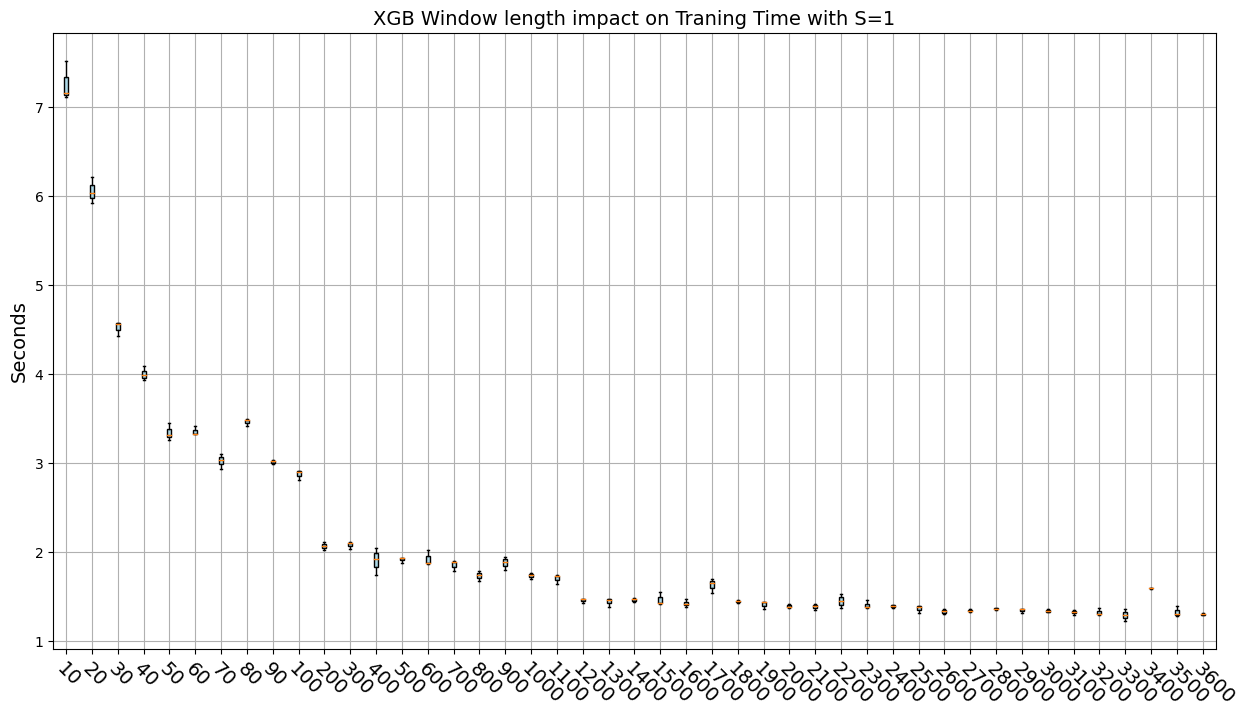

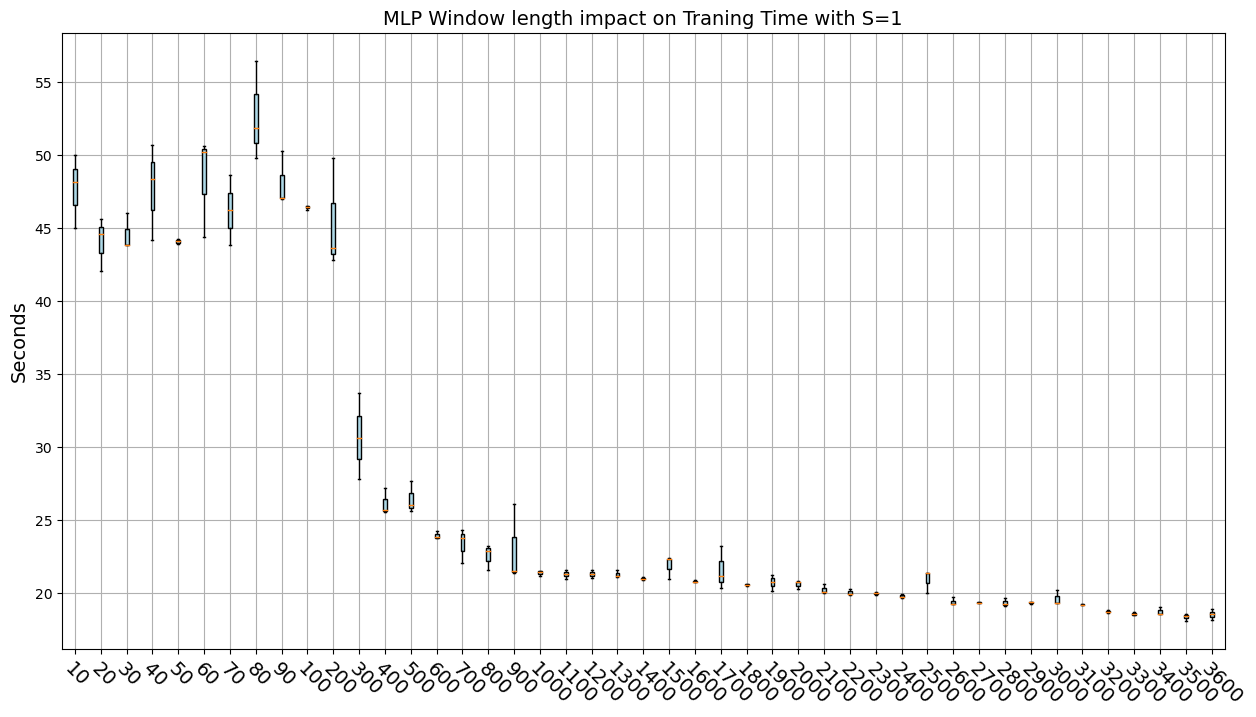

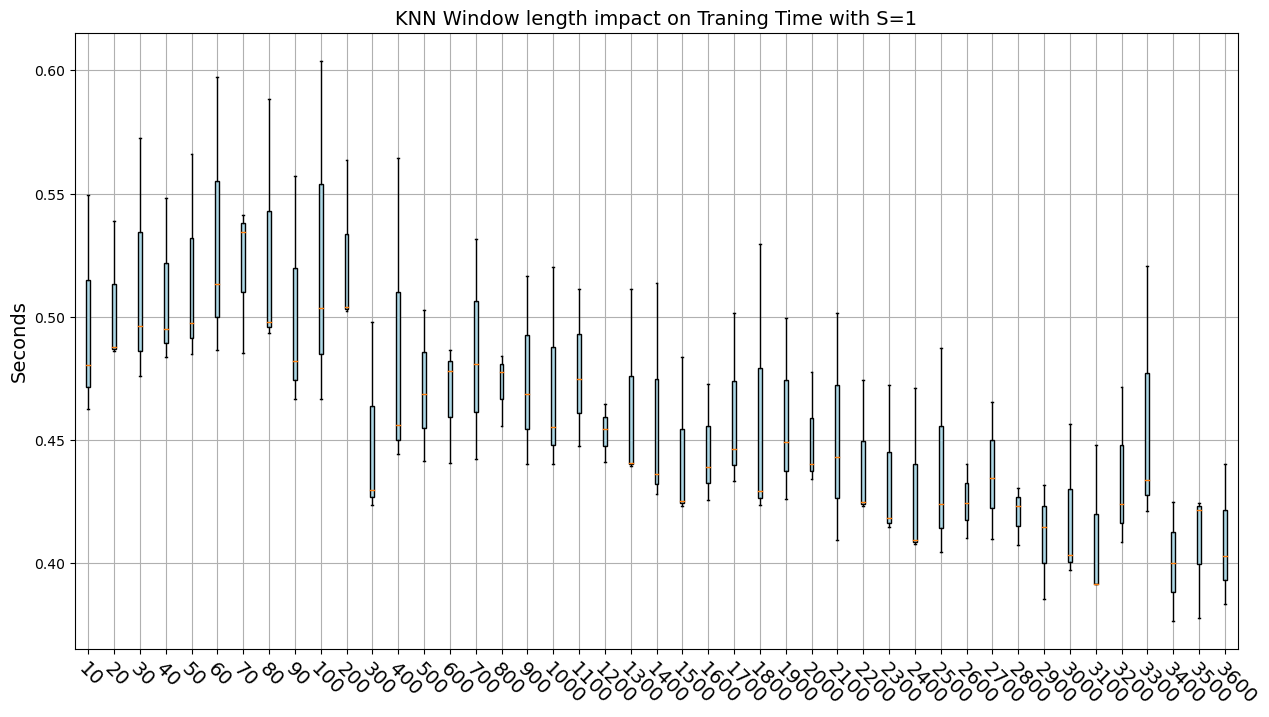

In [13]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange, spacingrange)

In [14]:
###############################################################################
###### Windows
###############################################################################

def draw_summary_plot(fig_folder, a_limit, b_limit, windowrange, spacingrange):

    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xvalues = None
    if len(windowrange) == 1:
        xvalues=np.array(spacingrange)
        subject = 'Spacing'
    else:
        xvalues=np.array(windowrange)
        subject = 'Window'

    A_XGB = A_XGB.reshape(-1, 1)
    GP_XGB = GP_XGB.reshape(-1, 1)
    GR_XGB = GR_XGB.reshape(-1, 1)
    GF1_XGB = GF1_XGB.reshape(-1, 1)

    A_DNN = A_DNN.reshape(-1, 1)
    GP_DNN = GP_DNN.reshape(-1, 1)
    GR_DNN = GR_DNN.reshape(-1, 1)
    GF1_DNN = GF1_DNN.reshape(-1, 1)

    A_KNN = A_KNN.reshape(-1, 1)
    GP_KNN = GP_KNN.reshape(-1, 1)
    GR_KNN = GR_KNN.reshape(-1, 1)
    GF1_KNN = GF1_KNN.reshape(-1, 1)

    fig, axs = plt.subplots(2, 2, sharex='all', figsize=(20,15))

    axs[0,0].plot(xvalues[a_limit:b_limit], A_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,0].set_xticks(xvalues)
    axs[0,0].tick_params(labelrotation=55)
    axs[0,0].set_title('Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].yaxis.grid(True)

    axs[0,1].plot(xvalues[a_limit:b_limit], GP_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,1].set_title('Precision')
    axs[0,1].set_ylabel('Precision')
    axs[0,1].tick_params(labelrotation=55)
    axs[0,1].yaxis.grid(True)

    axs[1,0].plot(xvalues[a_limit:b_limit], GR_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,0].set_title('Recall')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].tick_params(labelrotation=55)
    axs[1,0].yaxis.grid(True)

    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,1].set_title('F1-Score')
    axs[1,1].set_ylabel('F1-Score')
    axs[1,1].tick_params(labelrotation=55)
    axs[1,1].yaxis.grid(True)

    axs[1,0].set_xlabel(subject+' length, s')
    axs[1,1].set_xlabel(subject+' length, s')

    axs[1,1].legend(loc='best')

    title = 'Impact of ' + subject + ' length with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0])
    else:
        title = title + 'S=' + str(spacingrange[0])
    
    fig.suptitle(title)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+str(a_limit)+'_'+str(b_limit)+'_'+subject+'_duration.png')

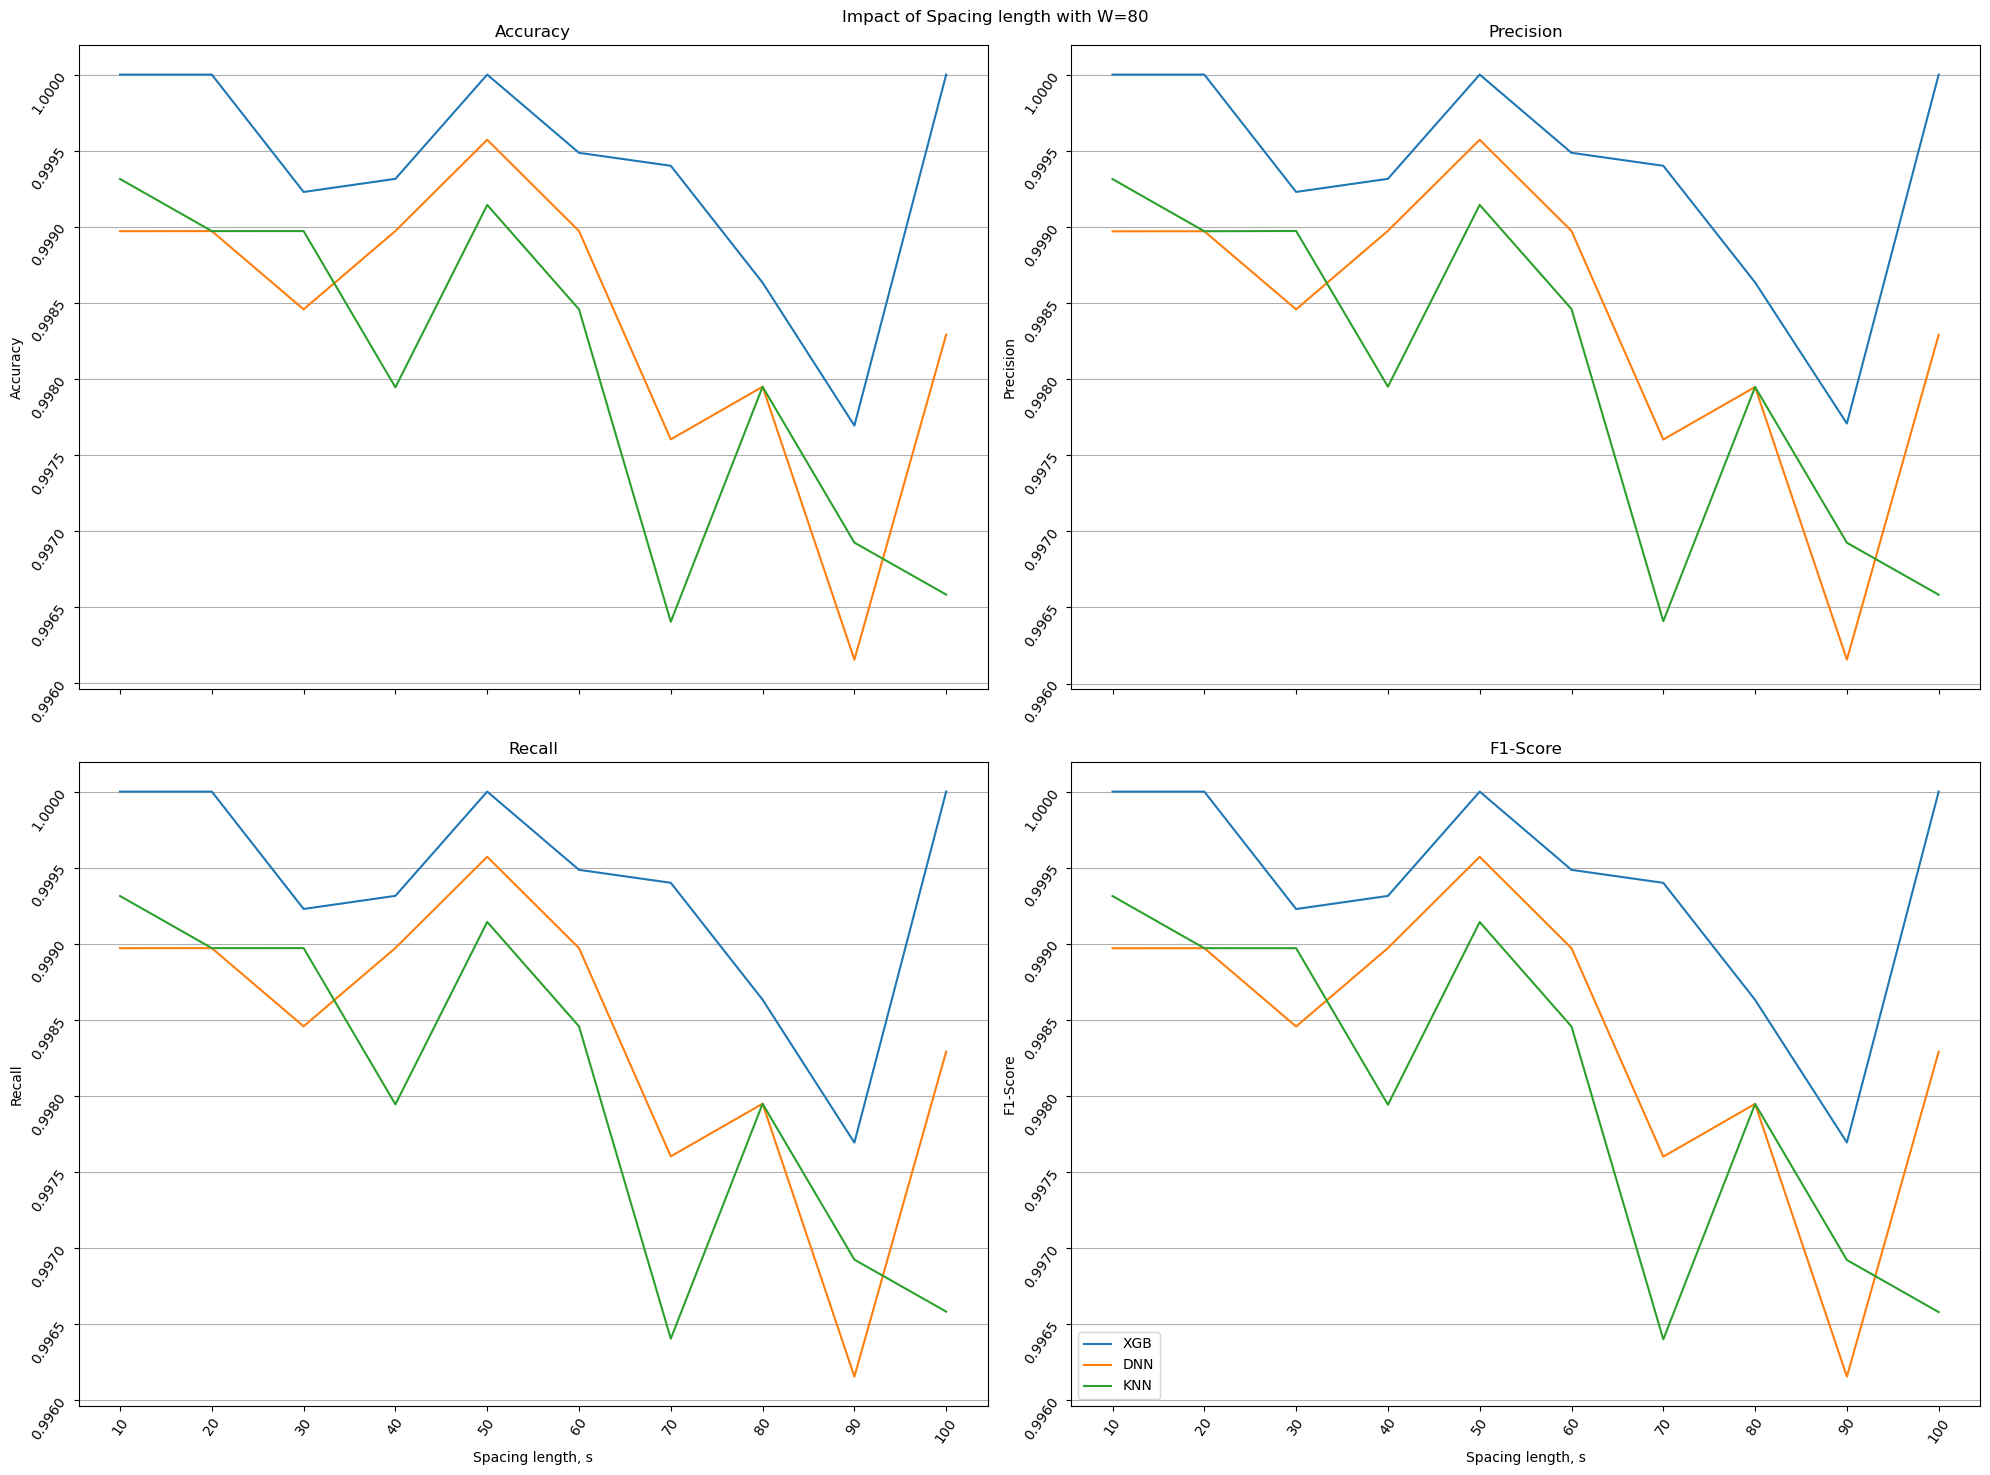

In [19]:
# Window Specific view
draw_summary_plot(fig_folder, 0, 10, windowrange, spacingrange)

In [16]:
###############################################################################
###### Spacing
###############################################################################
windowrange=[80]
spacingrange=list(range(10,161,10))

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=10 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.273237943649292
0.2790639400482178
0.2687337398529053
Training DNN...
7.3361124992370605
6.214810609817505
9.056036710739136
Training KNN...
0.044484853744506836
0.038335561752319336
0.03699827194213867
********************************
Iteration for spacing=20 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.1941056251525879
0.18602800369262695
0.17759299278259277
Training DNN...
4.085220575332642
5.066406488418579
3.5841188430786133
Training KNN...
0.014999628067016602
0.020998716354370117
0.02480006217956543
********************************
Iteration for spacing=30 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.1351318359375
0.15550589561462402
0.15320873260498047
Training DNN...
3.8757379055023193
4.400283336639404
3.717755079269409
Training KNN...
0.015022516250610352
0.009520292282104492
0.0110044479

([[0.273237943649292, 0.2790639400482178, 0.2687337398529053],
  [0.1941056251525879, 0.18602800369262695, 0.17759299278259277],
  [0.1351318359375, 0.15550589561462402, 0.15320873260498047],
  [0.12291646003723145, 0.135575532913208, 0.13696885108947754],
  [0.11645841598510742, 0.12957024574279785, 0.12352943420410156],
  [0.10221481323242188, 0.09921956062316895, 0.10160446166992188],
  [0.09900832176208496, 0.11404633522033691, 0.11469459533691406],
  [0.07325434684753418, 0.08689236640930176, 0.0960230827331543],
  [0.0950617790222168, 0.10413241386413574, 0.10583758354187012],
  [0.08198690414428711, 0.09822463989257812, 0.09822630882263184],
  [0.05336332321166992, 0.0865926742553711, 0.07940149307250977],
  [0.06532740592956543, 0.08215904235839844, 0.09793806076049805],
  [0.0643012523651123, 0.08446931838989258, 0.08467769622802734],
  [0.07333683967590332, 0.0882260799407959, 0.09385013580322266],
  [0.06134343147277832, 0.07342839241027832, 0.07500219345092773],
  [0.060972

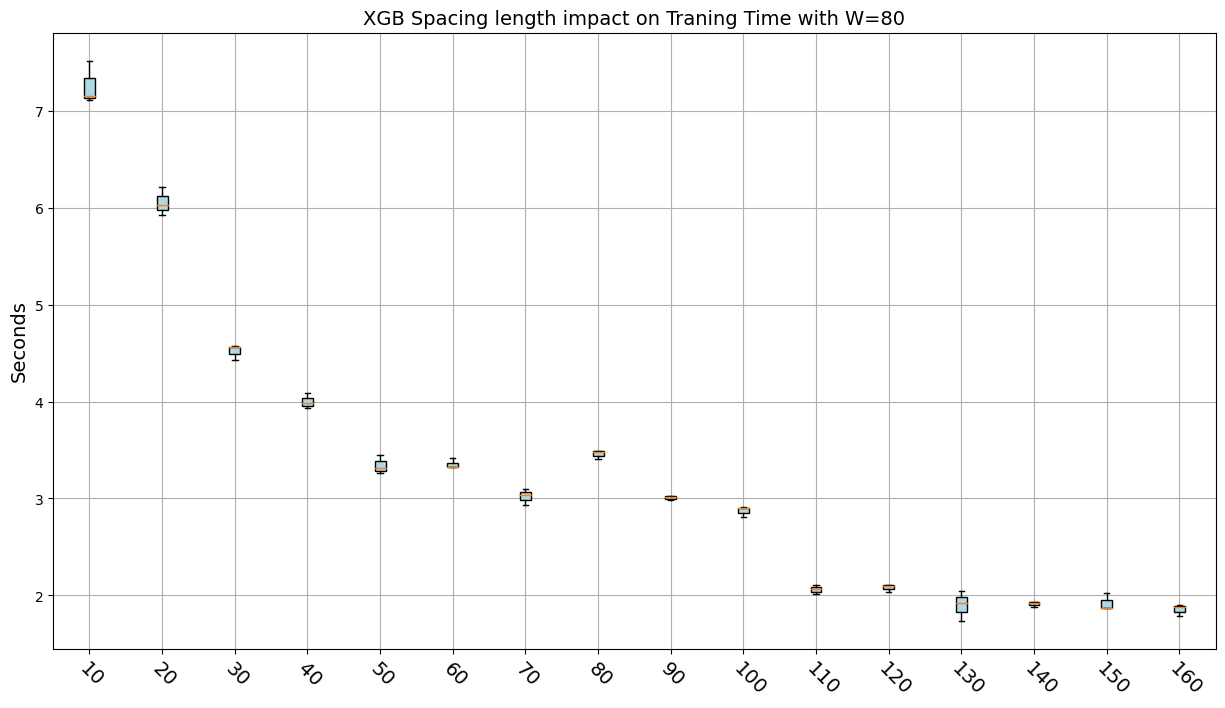

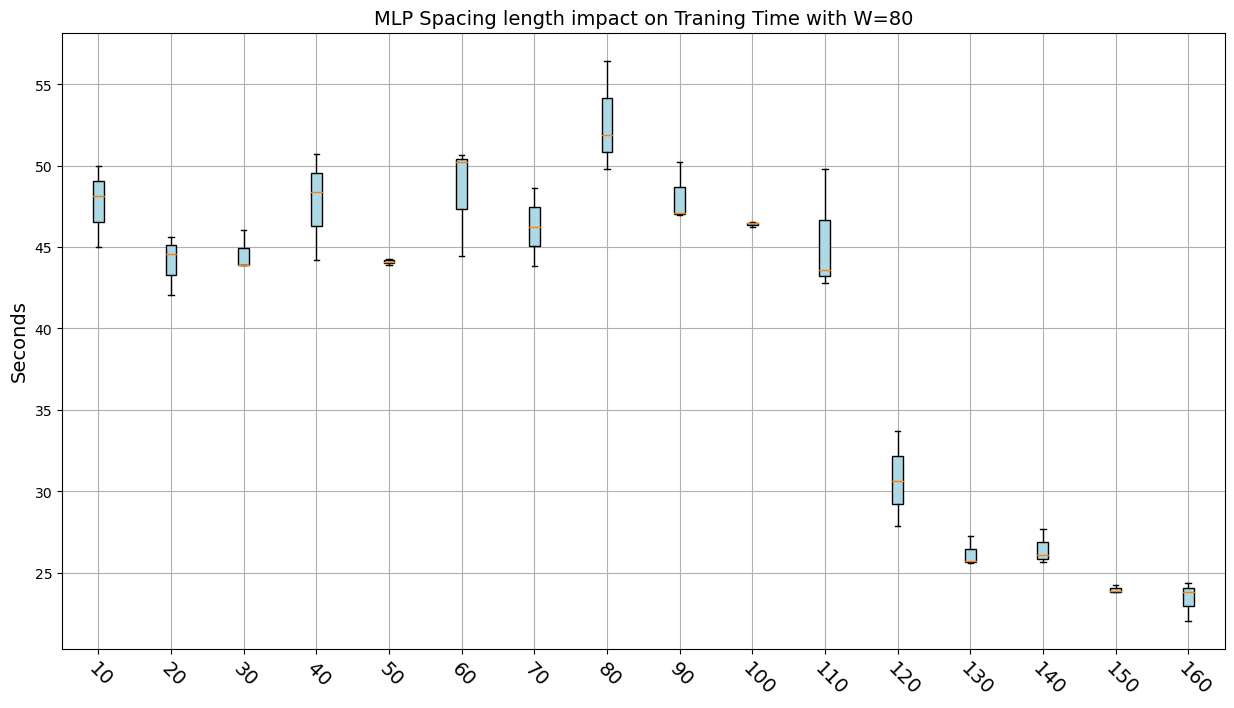

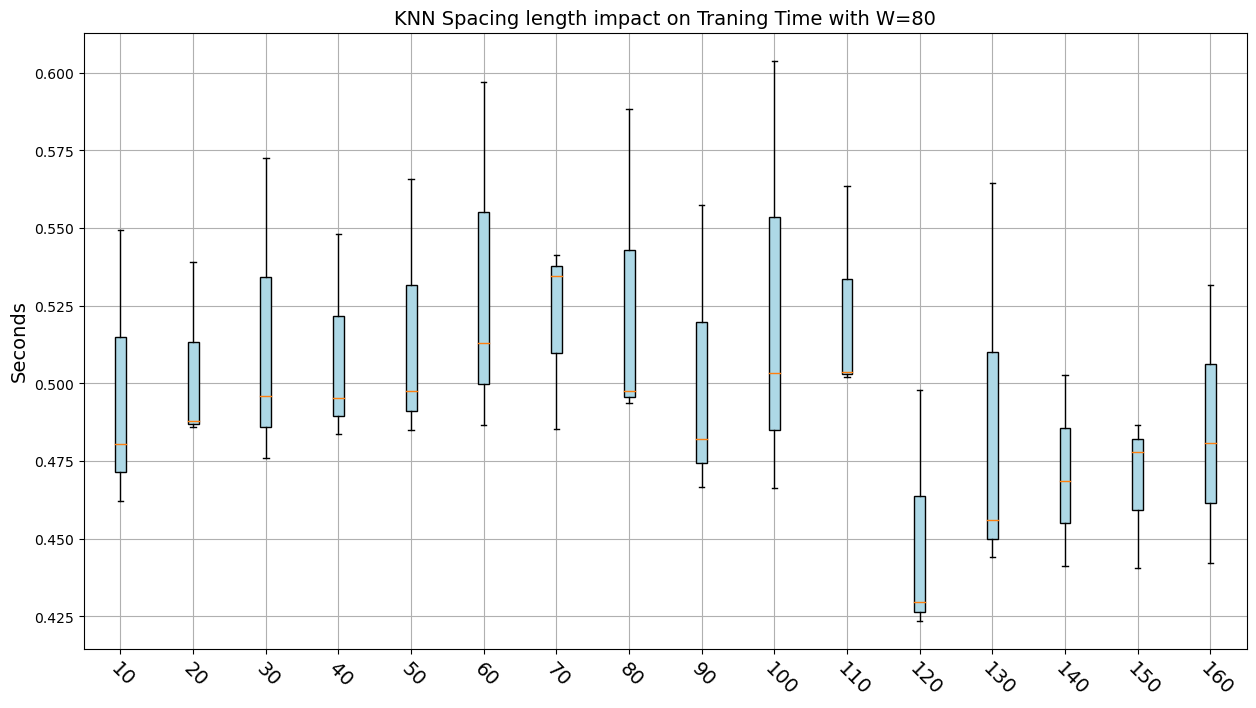

In [17]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange, spacingrange)

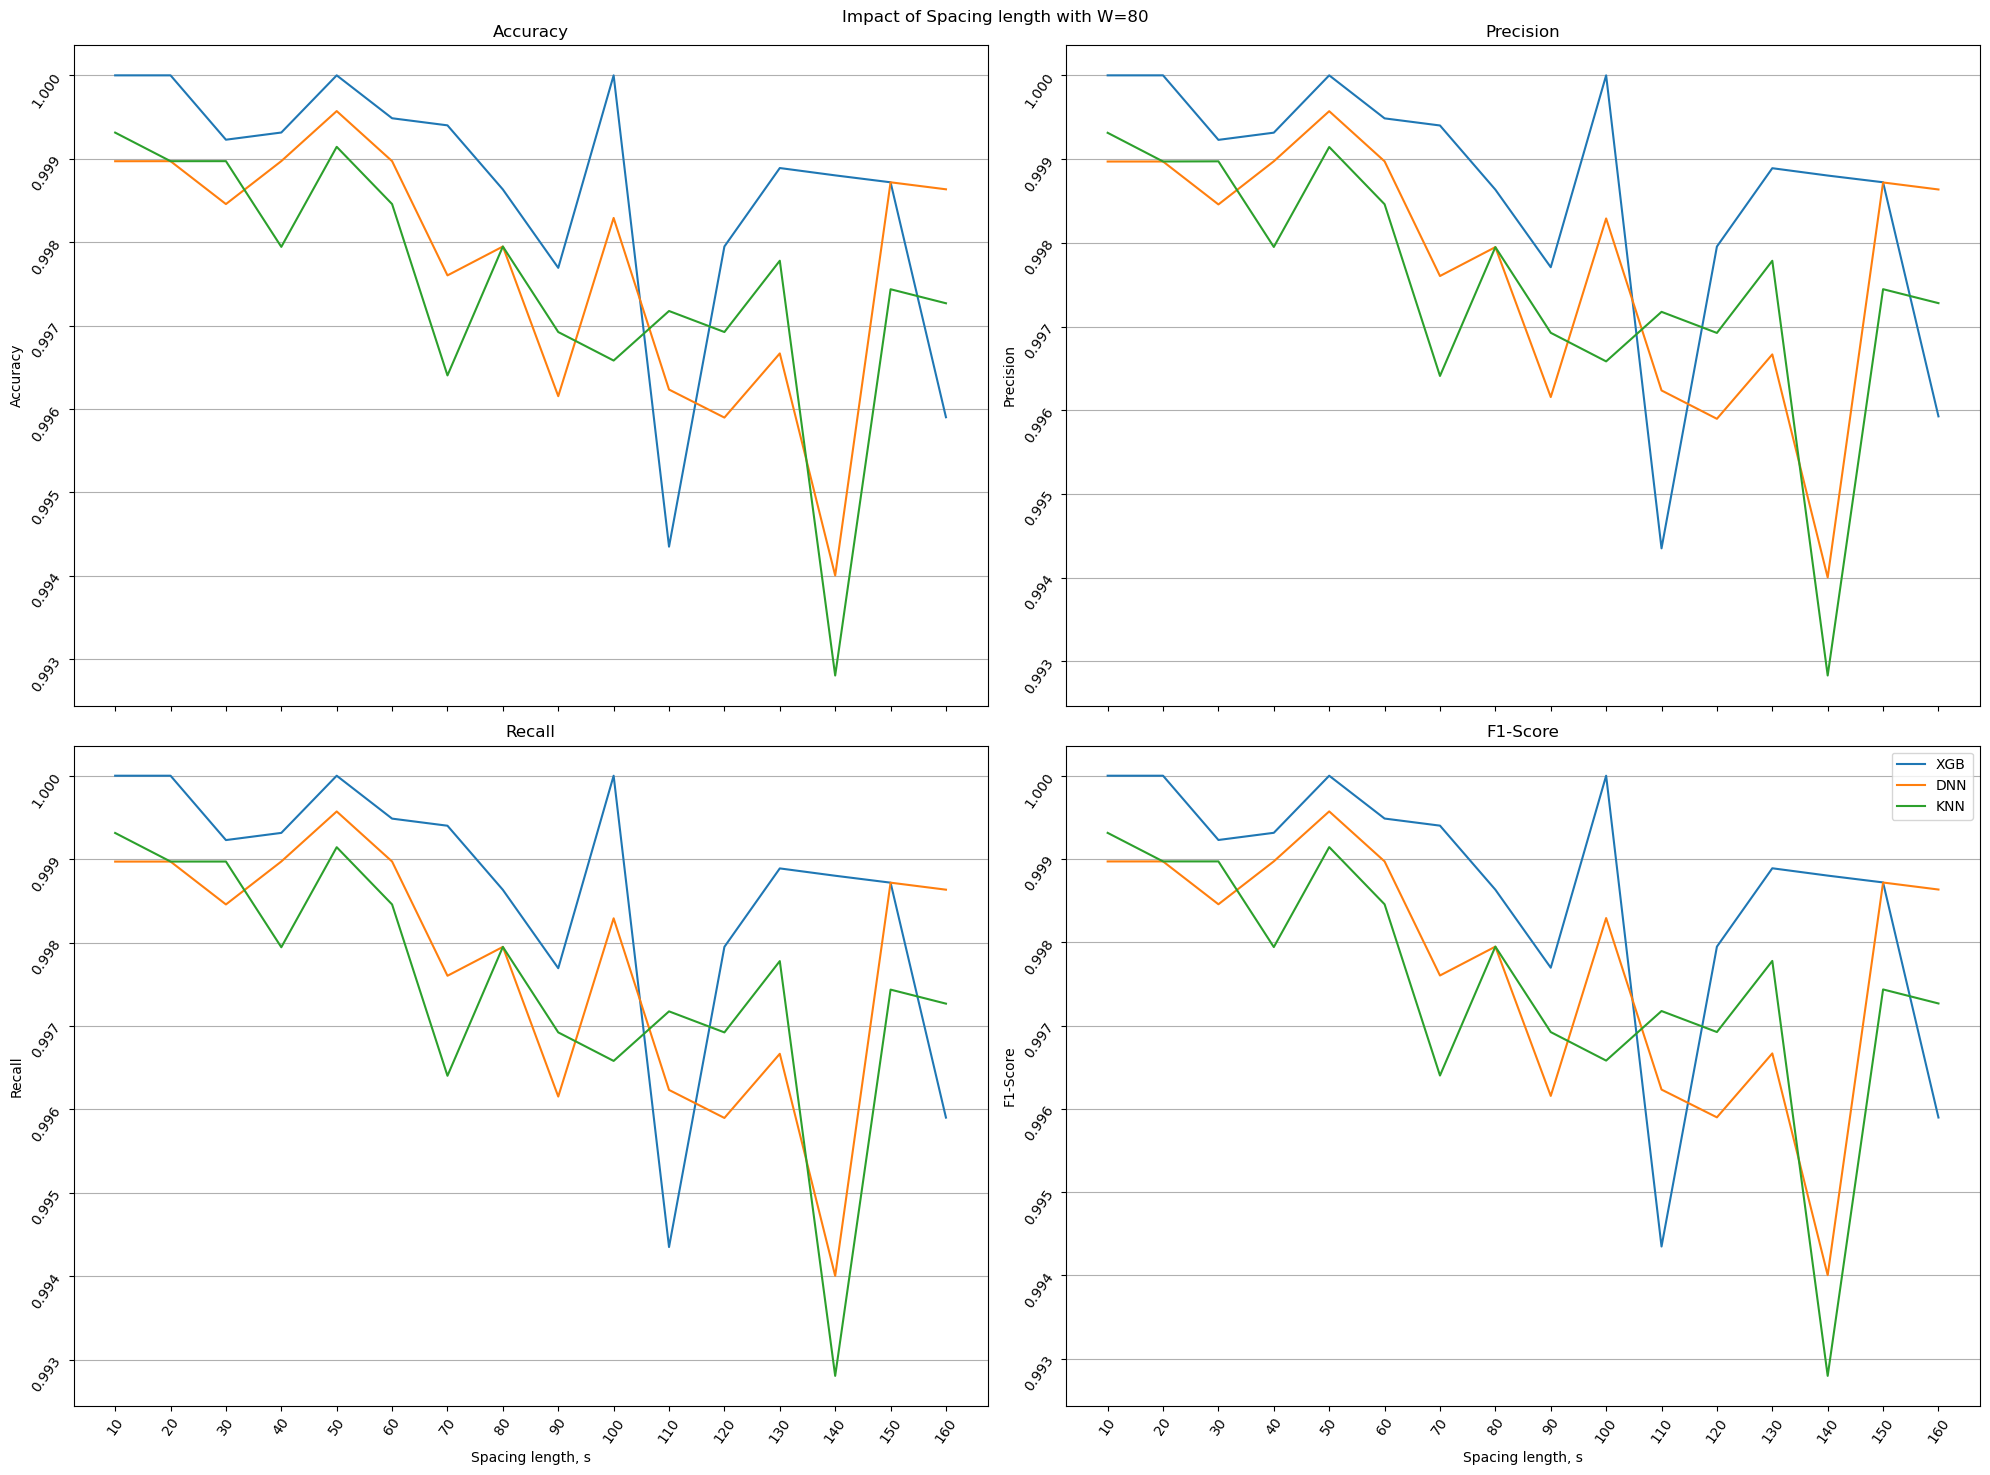

In [18]:
# Spacing Global view
draw_summary_plot(fig_folder, 0, len(A_KNN), windowrange, spacingrange)